In [1]:
%pylab inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

figsize(16, 9)

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'statsmodels'

Load the data.

In [2]:
df = pd.read_csv('jena_daily_temperatures.csv', parse_dates=['Date Time'], dayfirst=True, index_col='Date Time')
temperature = np.array(df['temperature'])

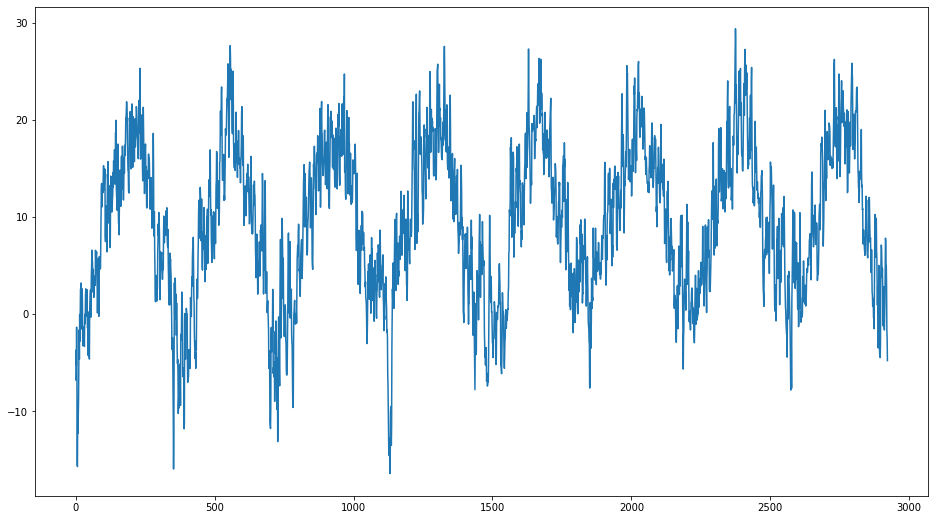

In [3]:
plt.figure(figsize=(16, 9))
plt.plot(temperature)

STL decomposition reveals that the temperature time series has a period of one year. Who would have thought...

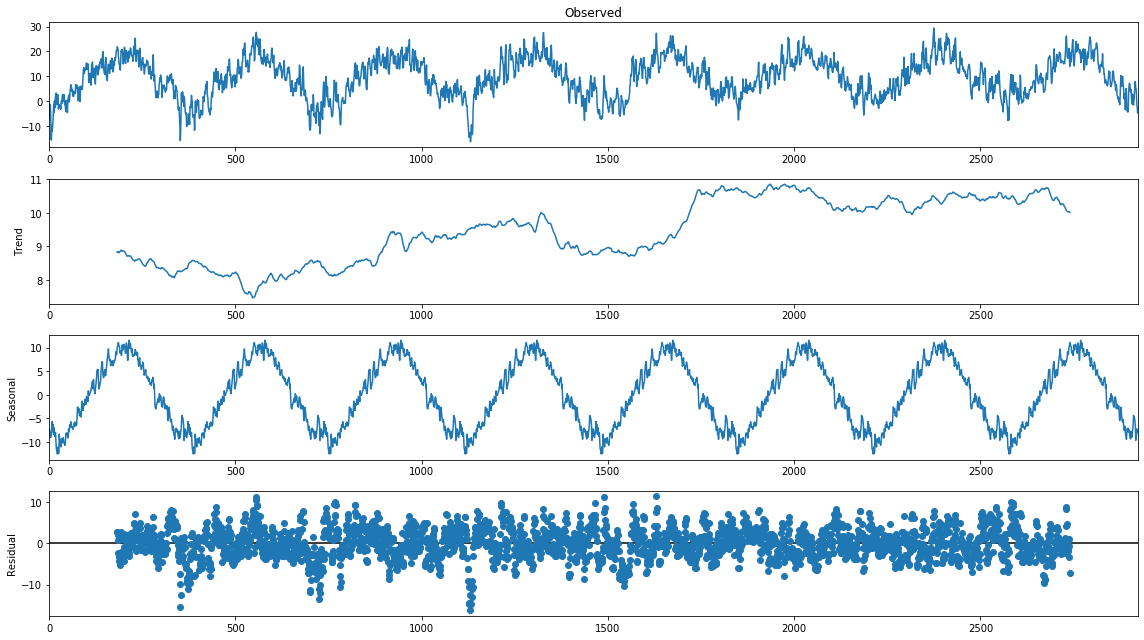

In [4]:
temperature_decomp = sm.tsa.seasonal_decompose(temperature, period=365)
_ = temperature_decomp.plot()

Split the time series into train and test parts.

In [5]:
split_point = int(len(temperature)*0.8)
temperature_train = temperature[:split_point]
temperature_test = temperature[split_point:]

We use $\mathrm{SARIMA}(5, 0, 0)(0, 1, 0)_{365}$ as it was identified to give the best results by trial and error.

In [6]:
model = sm.tsa.arima.ARIMA(temperature_train, order=(5, 0, 0), seasonal_order=(0, 1, 0, 365))
model = model.fit(method='innovations_mle', low_memory=True, cov_type='none')

/home/akonstantinov/.apps/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/arima/model.py:340: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  ' estimation by method "%s".' % method)


In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2338
Model:             ARIMA(5, 0, 0)x(0, 1, 0, 365)   Log Likelihood               -5119.269
Date:                           Tue, 05 Jan 2021   AIC                          10250.538
Time:                                   20:02:12   BIC                          10284.062
Sample:                                        0   HQIC                         10262.856
                                          - 2338                                         
Covariance Type:                            none                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9891        nan        nan        nan         nan         nan
ar.L2         -0.2518        nan        nan        nan         nan         nan
ar.L3          0.0490        nan        nan        nan         nan         nan
ar.L4         -0.0200        nan        nan        nan         nan         nan
ar.L5          0.0616        nan        nan        nan         nan         nan
sigma2        10.4941        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       43.39   Jarque-Bera (JB):                 8.07
Prob(Q):                              0.33   Prob(JB):                         0.02
Heteroskedasticity (H):               0.89   Skew:                             0.08
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

Compare the fitted values to the actual time series.

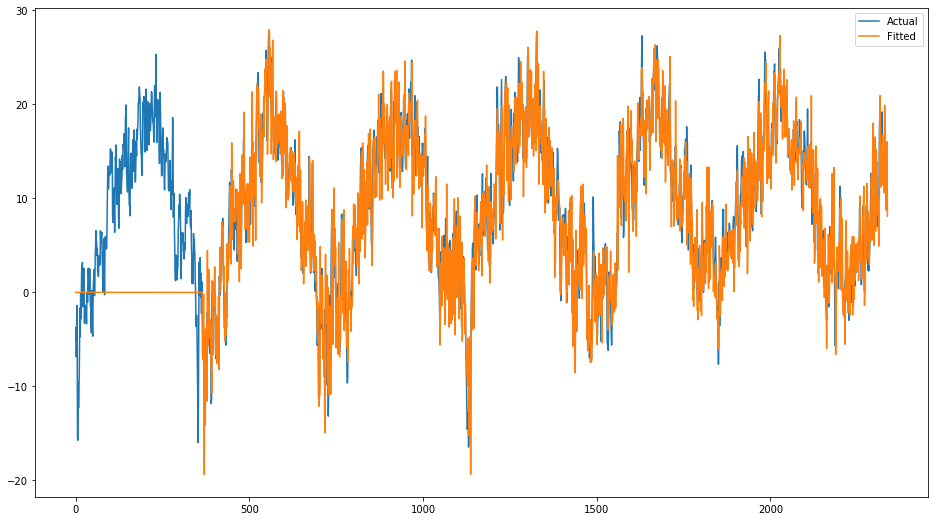

In [8]:
plt.figure(figsize=(16, 9))
plt.plot(temperature_train, label='Actual')
plt.plot(model.fittedvalues, label='Fitted')
plt.legend()

Test the model and evaluate the forecast against the actual future.

MAPE: 0.3140454995054399


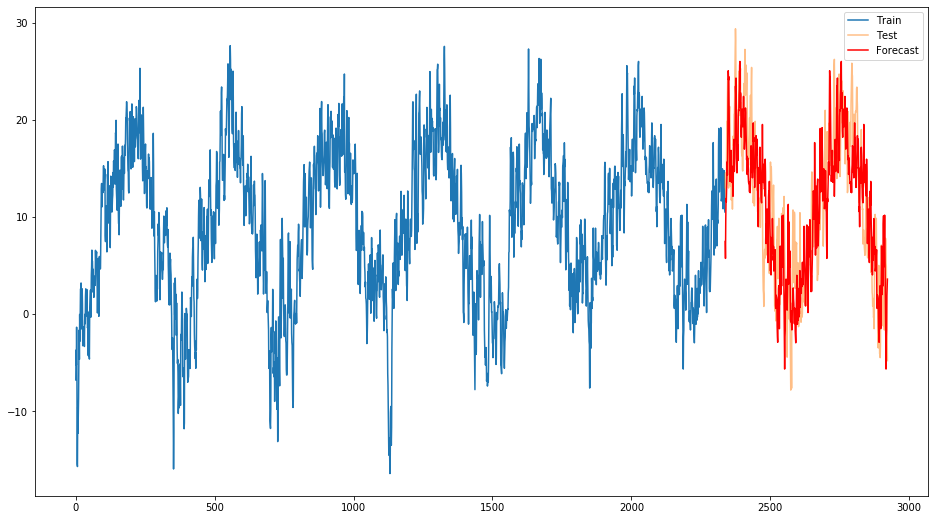

In [11]:
plt.figure(figsize=(16, 9))

start = len(temperature_train)
end = len(temperature_train) + len(temperature_test)

x = np.arange(start, end)
temperature_forecast = model.predict(start=start, end=end-1)

plt.plot(temperature_train, label='Train')
plt.plot(x, temperature_test, label='Test', alpha=0.5)
plt.plot(x, temperature_forecast, label='Forecast', color='red')
plt.legend()

# median here to compensate for some division by almost zero values of temperature
temperature_mape = np.median(np.abs((temperature_test - temperature_forecast)/temperature_test))
print(f'MAPE: {temperature_mape}')